<img src="Images/LL3-backdrop.png">

### Dates/Deadlines

Code: <i>29/04/2019 (one week before submission)</i><br />
Report: <i>05/05/2019 (20:00)</i><br />

### Imports

 You'll need to install the following libraries:
 * Gym (should have it by now)
 * Box2D
  * brew install swig
  * pip install box2d-py
  * pip install box2d


### Questions

 * Should we do [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2/) or [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/)?


### Comments
 
 * I think we should start with the discrete [LunarLander](https://gym.openai.com/envs/LunarLander-v2/) first then if we have the time attempt the continous one.
 
### Report

The project report should describe the problem you address, present your approach (or
approaches, if you experimented with more than one approach), and evaluate how well you have
solved the problem. It should also discuss alternative solution methods that are applicable, along
with the relative merits of your approach. Finally, the report should describe your personal
experience with the project, for example, the difficulties or any pleasant surprises you have
encountered along the way. Do not explain material that has been discussed in the lectures. For
example, there is no need to explain Q-learning or function approximation. 

Page limit: 8

### TO-DO

 * Create the agent
 * Save videos after $n$ iterations
 * Look into including the Neural Network like Mar.io (not important) 
 * We need to think of some "alternative solution" to this problem

 
### Links

 * [GitHub](https://github.bath.ac.uk/jwm59/RL-Robotics-Project)
 * [Trouble install Box2D - helped me](https://github.com/openai/gym/issues/100)
 * [More trouble shooting with Box2D](http://www.jtdz-solenoids.com/stackoverflow_/questions/44198228/install-pybox2d-for-python-3-6-with-conda-4-3-21)


In [1]:
#Importing
import gym
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

from IPython.display import clear_output, display #Not sure what this is doing exactly

import Box2D #Not sure we need this, check later

### Setting up the gym environment

## LunarLander-v2

* Observation Space: 8
 * X
 * Y
 * X velocity
 * Y velocity
 * Self angle
 * Angular velocity
 * Left leg contact 
 * Right lef contact
* Action Space: 4
 * Do nothing
 * Fire left orientation engine
 * Fire right orientation engine
 * Fire main engine


## LunarLanderContinuous-v2

* Observation Space: 8
 * X
 * Y
 * X velocity
 * Y velocity
 * Self angle
 * Angular velocity
 * Left leg contact 
 * Right lef contact
* Action Space: two real values vector from -1 to +1
 * First controls main engine, -1..0 off, 0..+1 throttle from 50% to 100% power
 * Second value -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off


In [2]:
env_discrete = gym.make('LunarLander-v2')
env_continuous = gym.make('LunarLanderContinuous-v2')

# Deep Q-learning

### Approach

"Probably should explain the approach we plan to take..."

In [59]:
## Creating Deep-Q network
def q_network(numInput, numHidden, numHiddenLayers, numOutput, optimiserFunction=tf.train.AdamOptimizer, \
              alpha=0.001, lossFunction="mse", hiddenActivation="tanh", outputActivation="linear"):
    
    #Creating a TensorFlow class
    network = tf.keras.models.Sequential()
    
    #Creating first hidden layer
    network.add(tf.keras.layers.Dense(numHidden, input_dim=numInput, activation=hiddenActivation))
    
    #Adding 'n' hidden layers
    for _ in range(numHiddenLayers):
        network.add(tf.keras.layers.Dense(numHidden, activation=hiddenActivation))
        
    #Creating output layer
    network.add(tf.keras.layers.Dense(numOutput, activation=outputActivation))
    
    #Defining the loss function, the optimiser and the metrics.
    network.compile(loss=lossFunction, optimizer=optimiserFunction(alpha))
    
    return network

In [62]:
## Creating agent
class rocketMan():
    def __init__(self, environment, numObservations, numActions, numHidden, numHiddenLayer, \
                         gamma=0.90, alpha=0.001, epsilon=0.2, load=False, save=True):
        
        self.numObservations = numObservations
        self.numActions = numActions
        self.numHidden = numHidden
        self.numHiddenLayer = numHiddenLayer
        
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.save = save
        self.load = load
        
        self.modelName = ''
        
        self.env = environment
        
        #Creating the neural network
        self.network = q_network(self.numObservations,self.numHidden,self.numHiddenLayer,self.numActions)
        
        
        ####IGNORE COPIED CODE
        #######################
        self.q_target_network = q_network(self.numObservations,self.numHidden,self.numHiddenLayer,self.numActions)
        self.soft_target_weight_update(1)
        #parameters
        self.df = 0.99 # discount factor
        self.tau = 0.95
        #replay buffer
        self.replay_buffer = []
        #######################
        
        self.checkpoint_path = "Training/cp.ckpt"
        self.checkpoint_dir = os.path.dirname(self.checkpoint_path)
        
        if(self.load):
            self.network.load_weights(self.checkpoint_path)
        
        if(self.save):
            self.cp_callback = tf.keras.callbacks.ModelCheckpoint(self.checkpoint_path, 
                                                                  save_weights_only=True, 
                                                                  verbose=0)        

    #COPIED
    #######################
    def soft_target_weight_update(self,tau):
        weights = np.asarray(self.network.get_weights())
        target_weights = np.asarray(self.q_target_network.get_weights())
        self.q_target_network.set_weights(weights * tau + target_weights * (1 - tau))
    ####################### 
            
    def getAction(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.network.predict(state)[0])
    
    #def learn_from_transition(self,action,state,next_state,reward,done_bool):
    def learn(self, state, action, state_prime, reward, finished):        
        finished = int(finished == 'true')        
        
        #COPIED
        #####################
        q_values = self.network.predict(state)

        target_q_values = q_values
        target_q_values[0][action] = reward + finished * self.df * \
                                    np.max(self.q_target_network.predict(state_prime))

        self.network.fit(state, target_q_values, epochs=1, batch_size=1, verbose=0)
        ####################
        
        '''
        oldQ = self.network.predict(state)
        targetQ = oldQ
        
        targetQ[0][action] = reward + finished * self.gamma * np.max(self.network.predict(state_prime)[0])
        self.network.fit(state, targetQ, epochs=1, batch_size=1, verbose=0, callbacks=[self.cp_callback])
        '''
        
    #COPIED
    ####################
    def learn_from_transition(self,action,state,next_state,reward,done_bool):
        q_values = self.network.predict(state)

        target_q_values = q_values
        target_q_values[0][action] = reward + done_bool * self.df \
                                            * np.max(self.q_target_network.predict(next_state))

        self.network.fit(state, target_q_values, epochs=1, batch_size=1, verbose=0)

    def learn_from_m_random_transitions_in_replay_buffer(self):
        size_of_replay_buffer = len(self.replay_buffer)
        for i in range(256):
            transition_index = random.randint(0, size_of_replay_buffer-1)
            action, state, next_state, reward, done_bool = self.replay_buffer[transition_index]
            self.learn_from_transition(action, state, next_state, reward, done_bool)
        self.soft_target_weight_update(0.5)
    ###############

### Training - Basic

Before looking into Experience Replay and Target Networks, I thought it would be best to implement a basic model first.

episode: 199 sum_of_rewards_for_episode: 10.0


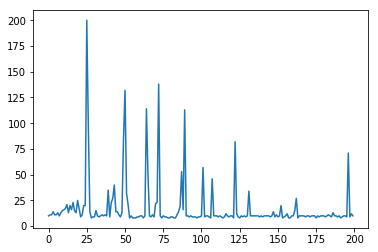

"\nfor episode in range(numEpisodes):\n    reward_sum = 0\n    \n    state = env.reset().reshape(1, numObservation)\n    finished = False\n    #for i in range(maxSteps):\n    while not finished:\n        action = agent.getAction(state)        \n\n        state_prime, reward, finished, info = env.step(action)\n        state_prime = state_prime.reshape(1, numObservation)\n    \n        agent.learn(state, action, state_prime, reward, finished)\n\n        state = state_prime\n        \n        reward_sum += reward\n        if finished:\n            clear_output(wait=True)\n            rewardList.append(reward_sum)\n            print('episode:', episode, 'sum_of_rewards_for_episode:', reward_sum)\n            break\n        if(episode % numEpisodes/4) == 0:\n            env.render()\n            \n    env.close()             \nenv.close()\n\nplt.plot(range(numEpisodes), rewardList)\nplt.show()\n"

In [63]:
import random

# Training the agnet
#env = env_discrete #Change this depending on what environemnt we want
env = gym.make("CartPole-v0")

numObservation = env.observation_space.shape[0]
numActions = env.action_space.n
numHidden = 16
numHiddenLayer = 1

agent = rocketMan(env, numObservation, numActions, numHidden, numHiddenLayer, save=True, load=False)

numEpisodes = 200
maxSteps = 256

rewardList = []
for episode in range(numEpisodes):
    reward_sum = 0
    state = env.reset().reshape(1, numObservation)
    done = False
    
    #for i in range(maxSteps):
    while not done:
        if episode > 50: agent.epsilon = 0
        action = agent.getAction(state)

        next_state, reward, done, info = env.step(action)
        next_state = next_state.reshape(1, numObservation)
z
        agent.replay_buffer.append((action,state,next_state,reward,int(done == 'true')))

        state = next_state.reshape(1, numObservation)

        reward_sum += reward
        if done:
            clear_output(wait=True)
            print('episode:', episode, 'sum_of_rewards_for_episode:', reward_sum)
            agent.learn_from_m_random_transitions_in_replay_buffer()
            break
    rewardList.append(reward_sum)
    
    if(episode == numEpisodes-1):
        env.render()
    env.close()
env.close()

plt.plot(range(numEpisodes), rewardList)
plt.show()
'''
for episode in range(numEpisodes):
    reward_sum = 0
    
    state = env.reset().reshape(1, numObservation)
    finished = False
    #for i in range(maxSteps):
    while not finished:
        action = agent.getAction(state)        

        state_prime, reward, finished, info = env.step(action)
        state_prime = state_prime.reshape(1, numObservation)
    
        agent.learn(state, action, state_prime, reward, finished)

        state = state_prime
        
        reward_sum += reward
        if finished:
            clear_output(wait=True)
            rewardList.append(reward_sum)
            print('episode:', episode, 'sum_of_rewards_for_episode:', reward_sum)
            break
        if(episode % numEpisodes/4) == 0:
            env.render()
            
    env.close()             
env.close()

plt.plot(range(numEpisodes), rewardList)
plt.show()
'''